## Summary
This notebook checking how XCEPTION prebuilt model gets trained on detecting abnormalities in a image using gradient heatmap for demonstration

Credits: Jayson https://github.com/ssaurbier/Covid-CT-NN-Classification/blob/main/Jupyter_Notebooks/01_Data_Notebook_Jayson-2.ipynb

In [57]:
# Imports
import pandas as pd
import numpy as np
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tensorflow import (
    GradientTape,
    argmax,
    reduce_mean,
    squeeze,
    maximum,
    math,
    newaxis,
)
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import preprocessing

from skimage.transform import resize
from scipy import sparse
from IPython.display import Image, display

import pydicom
import cv2


In [58]:
# Set image folder
image_folder = "breast_imaging_300px"


In [59]:
# Load no duplicate patient dataset
df = pd.read_csv("../../data/no_dubs_train.csv")
df.head(1)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,custom_id
0,1,29919,1361547019,1,0,58.0,1,1,1,0,0,1.0,False,29919-R


In [60]:
# Positive Cancer Patients
p_2 = df[
    (df["view"] == 1)
    & (df["laterality"] == 0)
    & (df["invasive"] == 0)
    & (df["density"] == 1)
    & (df["difficult_negative_case"] == 0)
    & (df["cancer"] == 1)
].iloc[0:1]

p_3 = df[
    (df["view"] == 0)
    & (df["laterality"] == 0)
    & (df["invasive"] == 0)
    & (df["density"] == 2)
    & (df["difficult_negative_case"] == 0)
    & (df["cancer"] == 1)
].iloc[0:1]

# Negative Cancer Patients
p_4 = df[
    (df["view"] == 0)
    & (df["laterality"] == 0)
    & (df["invasive"] == 0)
    & (df["density"] == 1)
    & (df["difficult_negative_case"] == True)
    & (df["cancer"] == 0)
].iloc[0:1]

p_5 = df[
    (df["view"] == 1)
    & (df["laterality"] == 1)
    & (df["invasive"] == 0)
    & (df["density"] == 0)
    & (df["difficult_negative_case"] == False)
    & (df["cancer"] == 1)
].iloc[0:1]


In [61]:
# Concat 5 picked patients
df = pd.concat([p_2, p_3, p_4, p_5])
df.reset_index()


,index,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,custom_id
0,6,1,28057,72206775,0,1,73.0,1,1,0,0,0,1.0,False,28057-L
1,148,1,55147,1239502036,0,0,62.0,1,1,0,0,0,2.0,False,55147-L
2,1440,1,48994,1401008057,0,0,56.0,0,0,0,0,0,1.0,True,48994-L
3,479,1,20251,401181500,1,1,65.0,1,1,0,0,0,0.0,False,20251-R


In [62]:
def extract_patient_image_file_path(
    target_folder,
    df,
    base_path,
    target_A,
    target_B,
    patient_col,
    image_id_col,
    image_uri_col,
    is_test=False,
):
    """Function to construct image file path

    Args:
        target_folder (string): Image folder
        df (DataFrame): Pandas dataframe
        base_path (string): Base path to folders
        target_A (string): Cancer path
        target_B (string): No Cancer path
        patient_col (string): Patient column name
        image_id_col (string): Image id column name
        image_uri_col (string): Image uri column name
        is_test (bool, optional): If test dataset is given. Defaults to False.
    """
    if not is_test:
        cancer_path = f"{target_folder}/{target_A}"
        no_cancer_path = f"{target_folder}/{target_B}"
    else:
        test_path = f"{target_folder}/{target_A}"

    for index in df.index.tolist():
        path = ""
        img_prefix = ""
        patient_id = df.loc[index, patient_col]

        if not is_test:
            if df.loc[index, target_A] == 0:
                img_prefix = target_B
                path = f"{base_path}{no_cancer_path}/{patient_id}"

            else:
                img_prefix = target_A
                path = f"{base_path}{cancer_path}/{patient_id}"
        else:
            img_prefix = target_A
            path = f"{base_path}{test_path}/{patient_id}"

        patient_img_id = df.loc[index, image_id_col]

        path = f"{path}/{img_prefix}_{patient_id}_{patient_img_id}.npz"
        dcm_path = f"{base_path}/train_images/{patient_id}/{patient_img_id}.dcm"
        if os.path.exists(path):
            df.loc[index, image_uri_col] = path
            df.loc[index, "dcm_uri"] = dcm_path


In [63]:
# Run path extraction
extract_patient_image_file_path(
    image_folder, df, '../../data/', 
    'cancer', 'no_cancer', 'patient_id', 'image_id', 'img_uri')

In [64]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,custom_id,img_uri,dcm_uri
6,1,28057,72206775,0,1,73.0,1,1,0,0,0,1.0,False,28057-L,../../data/breast_imaging_300px/cancer/28057/c...,../../data//train_images/28057/72206775.dcm
148,1,55147,1239502036,0,0,62.0,1,1,0,0,0,2.0,False,55147-L,../../data/breast_imaging_300px/cancer/55147/c...,../../data//train_images/55147/1239502036.dcm
1440,1,48994,1401008057,0,0,56.0,0,0,0,0,0,1.0,True,48994-L,../../data/breast_imaging_300px/no_cancer/4899...,../../data//train_images/48994/1401008057.dcm
479,1,20251,401181500,1,1,65.0,1,1,0,0,0,0.0,False,20251-R,../../data/breast_imaging_300px/cancer/20251/c...,../../data//train_images/20251/401181500.dcm


In [65]:
# Load XCEPTION model
model_builder = Xception
model = model_builder(weights="imagenet")

In [66]:
def convert_image_to_3_channel(org_img):
    """Converts single channel image into 3 channels

    Args:
        org_img (numpy array): Single channel image

    Returns:
        numpy array: 3 channeled image
    """
    # Initialize 3 channeled image template filled with 0
    img = np.zeros((np.array(org_img).shape[0], np.array(org_img).shape[1], 3))

    # same value in each channel
    img[:, :, 0] = org_img
    img[:, :, 1] = org_img
    img[:, :, 2] = org_img

    return img


In [67]:
def construct_image_array(sparse_dir_list):
    """Build image array from given file path list

    Args:
        sparse_dir_list (list): Sparse matrix path list

    Returns:
        numpy array: 3 channeled image
    """
    # Init list for image data
    image_data = []

    # Loop through directory list passed where sparse matrix stored
    for sparse_path in sparse_dir_list:
        # Load sparse matrix file
        sparse_matrix = sparse.load_npz(sparse_path)
        # Convert mammogram into 3 channeled image
        three_channel_image = convert_image_to_3_channel(sparse_matrix.todense())
        # Append new 3 channeled list into image data list
        image_data.append(three_channel_image)

    # Convert image data list into numpy array
    image_data = np.array(image_data)
    # Return the result
    return image_data


In [68]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Create gradcam and heatmap

    Args:
        img_array (numpy array): Image
        model (keras model): Tensorflow model
        last_conv_layer_name (string): Last convolutional layer
        pred_index (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., newaxis]
    heatmap = squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = maximum(heatmap, 0) / math.reduce_max(heatmap)
    return heatmap.numpy()

In [69]:
# Last convolutional layer
last_conv_layer_name = "block14_sepconv2_act"

In [70]:
# preprocess every photo within the list_img_paths
processed_images_grad = []
for i in df.index.tolist():
    # Remove last layer's softmax
    model.layers[-1].activation = None
    # Preprocess image
    img_array = preprocess_input(construct_image_array([df.loc[i, "img_uri"]]))
    # Resize
    reshaped_image = resize(img_array, (1, 299, 299, 3), anti_aliasing=True)
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(reshaped_image, model, last_conv_layer_name)
    # Store heatmap
    processed_images_grad.append(heatmap)


In [71]:
image_array = []
# Function from Keras Tutorial
def save_and_display_gradcam(
    img_path, dcm_path, heatmap, cam_path="cam.jpg", alpha=0.6
):
    """Creates and saves gradcam heatmap

    Args:
        img_path (string): jpeg image file path
        dcm_path (string): dicom file path
        heatmap (_type_): Generated heatmap
        cam_path (str, optional): File path to store images. Defaults to "cam.jpg".
        alpha (float, optional): Transparency level. Defaults to 0.6.
    """
    # Load the original image
    img = construct_image_array([img_path])[0]
    # img = reshaped_image = resize(
    #             img_array, (1, 299, 299, 3), anti_aliasing=True
    #         )

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

    ds = pydicom.dcmread(f"{dcm_path}")
    image_array.append(ds.pixel_array)
    image_array.append(cv2.imread(cam_path))


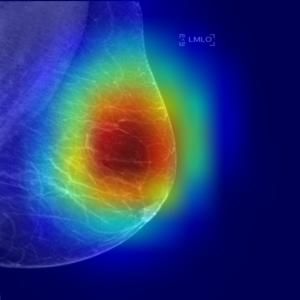

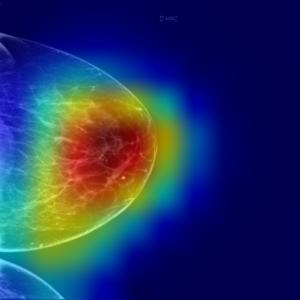

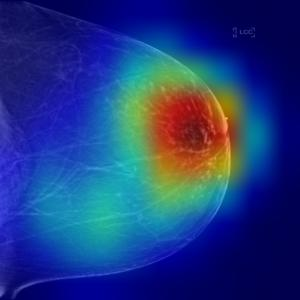

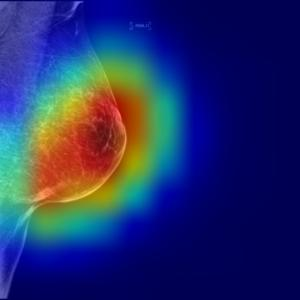

In [72]:
# Get image path lists
list_img_paths = df["img_uri"].tolist()
list_dcm_paths = df["dcm_uri"].tolist()

# Traverse image paths
for i in range(len(list_img_paths)):
    save_and_display_gradcam(
        list_img_paths[i],
        list_dcm_paths[i],
        processed_images_grad[i],
        cam_path=f"../../charts/model_diagnosis/breast_xception_vision_{i}.jpg",
        alpha=0.1,
    )


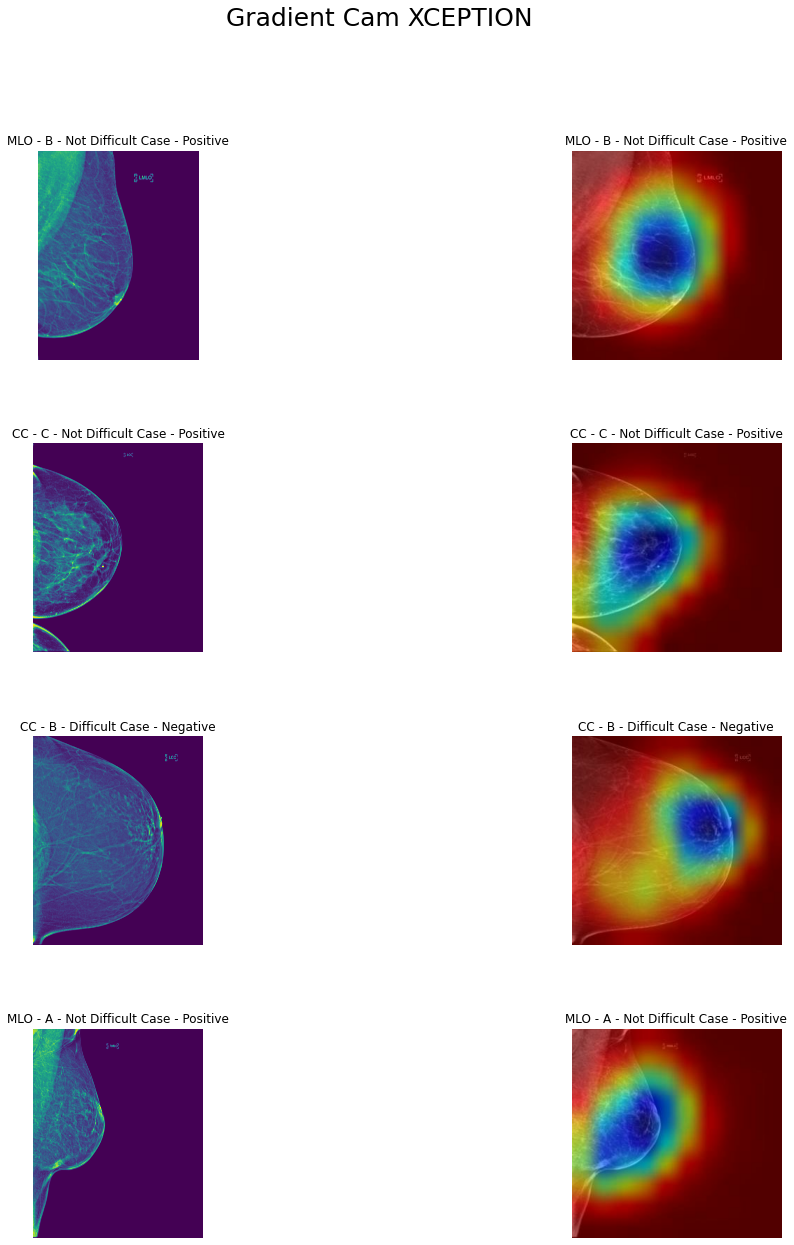

In [74]:
# Titles for graph
titles = [
    "MLO - B - Not Difficult Case - Positive",
    "MLO - B - Not Difficult Case - Positive",
    "CC - C - Not Difficult Case - Positive",
    "CC - C - Not Difficult Case - Positive",
    "CC - B - Difficult Case - Negative",
    "CC - B - Difficult Case - Negative",
    "MLO - A - Not Difficult Case - Positive",
    "MLO - A - Not Difficult Case - Positive",
]
# Set up layout
fig, axs = plt.subplots(
    4,
    2,
    figsize=(20, 20),
    squeeze=False,
    gridspec_kw={
        "wspace": 0,
        "hspace": 0.4,
    },
)

fig.suptitle("Gradient Cam XCEPTION", fontsize=25)
for i, (img, title) in enumerate(zip(image_array, titles)):
    axs[i // 2, i % 2].imshow(img)
    axs[i // 2, i % 2].axis("off")
    axs[i // 2, i % 2].set_title(title)
    
plt.savefig("../../charts/model_diagnosis/breast_xception_heatmap.jpg")
